In [1]:
import pydotplus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.tree import (DecisionTreeClassifier, export_graphviz)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, VotingClassifier)
from IPython.display import Image

### import data

In [2]:
data = pd.read_csv('../../Data/WeatherOutagesAllJerry.csv')

In [3]:
# clean up data
data = data.dropna(how = 'all')
data = data.fillna(0)
data = data.round(4)

In [4]:
# # of outages apart from equipment outage
natural = data['natural'] = data.Trees + data.Animals + data.Lightning
pd.set_option('display.max_columns', 500)
data.head(5)

,Date,Total_outages,Equipment,Trees,Animals,Lightning,Day_length_hr,Max_temp_F,Avg_Temp_F,Min_temp_F,Max_humidity_percent,Avg_humidity_percent,Min_humidity_percent,Max_visibility_mi,Avg_visibility_mi,Min_visibility_mi,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in,Events,Event_fog,Event_rain,Event_snow,Event_thunderstorm,Event_Hail,Event_Tornado,natural
0,9/11/00,0.0,0.0,0.0,0.0,0.0,12.7833,66.0,58.0,50.0,100.0,89.0,58.0,10.0,6.0,0.0,8.0,2.0,9.0,0.01,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9/12/00,2.0,1.0,0.0,1.0,0.0,12.7167,75.0,62.0,52.0,100.0,69.0,33.0,10.0,10.0,7.0,8.0,4.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9/13/00,1.0,1.0,0.0,0.0,0.0,12.6667,77.0,64.0,54.0,97.0,74.0,52.0,10.0,10.0,10.0,16.0,7.0,25.0,0.00,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9/14/00,0.0,0.0,0.0,0.0,0.0,12.6167,84.0,71.0,60.0,87.0,66.0,39.0,10.0,10.0,10.0,17.0,12.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9/15/00,1.0,1.0,0.0,0.0,0.0,12.5500,73.0,66.0,59.0,97.0,79.0,53.0,10.0,10.0,10.0,12.0,5.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data['Total_outages'].max()

49.0

In [6]:
data['natural'].max()

47.0

In [7]:
data['Equipment'].max()

9.0

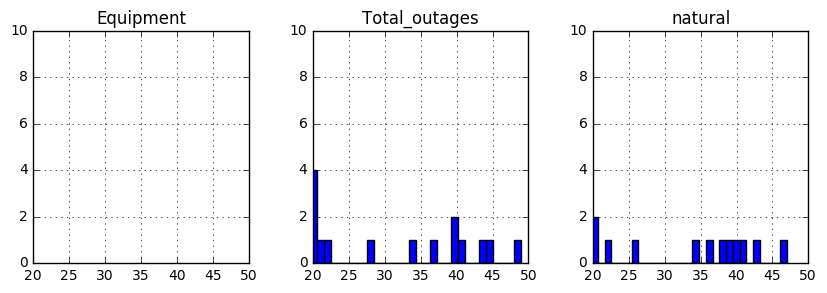

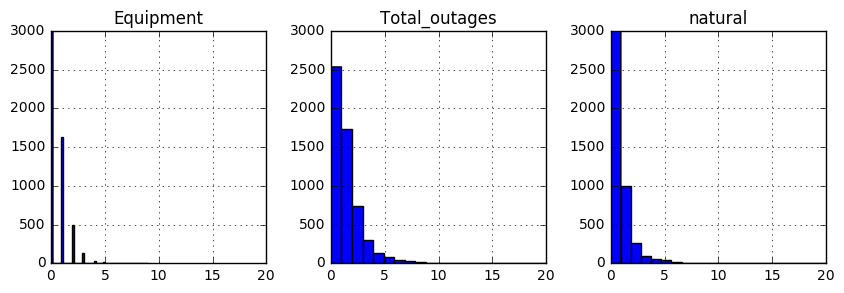

In [8]:
# look at the distribution of power outages

for array in data[['Total_outages','natural','Equipment']].hist(figsize=(10,3),layout=(1,3),bins=50):
    for subplot in array:
        subplot.set_xlim((20,50))
        subplot.set_ylim((0,10))
        
for array in data[['Total_outages','natural','Equipment']].hist(figsize=(10,3),layout=(1,3),bins=50):
    for subplot in array:
        subplot.set_xlim((0,20))
        subplot.set_ylim((0,3000))
        
#0-2, 3-8, >9

{'boxes': [<matplotlib.lines.Line2D at 0x11307cc50>],
 'caps': [<matplotlib.lines.Line2D at 0x113084fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x11308ef28>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x113088fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11307ce80>,
  <matplotlib.lines.Line2D at 0x113084e48>]}

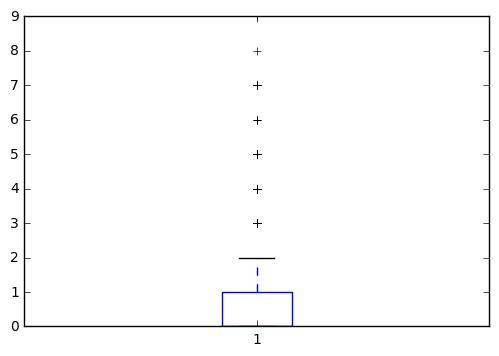

In [9]:
plt.boxplot(data.Equipment)

In [10]:
#data[['Max_temp_F','Avg_Temp_F','Min_temp_F']].plot()
#data[['Max_humidity_percent','Avg_humidity_percent','Min_humidity_percent']].plot()
#data[['Max_visibility_mi']].plot()
#data[['Avg_visibility_mi']].plot()

In [11]:
# convert to classification problem
def f(row):
    """function that categories days with more than 8 outages as extreme, 
                                3-8 outages as bad, and 0-2 as normal"""
    if row['Total_outages'] > 8:
        val = 'extreme'
    elif row['Total_outages'] > 2:
        val = 'bad'
    else:
        val = 'normal'
    return val

data['category'] = data.apply(f, axis=1)

In [12]:
data.head(2)

,Date,Total_outages,Equipment,Trees,Animals,Lightning,Day_length_hr,Max_temp_F,Avg_Temp_F,Min_temp_F,Max_humidity_percent,Avg_humidity_percent,Min_humidity_percent,Max_visibility_mi,Avg_visibility_mi,Min_visibility_mi,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in,Events,Event_fog,Event_rain,Event_snow,Event_thunderstorm,Event_Hail,Event_Tornado,natural,category
0,9/11/00,0.0,0.0,0.0,0.0,0.0,12.7833,66.0,58.0,50.0,100.0,89.0,58.0,10.0,6.0,0.0,8.0,2.0,9.0,0.01,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
1,9/12/00,2.0,1.0,0.0,1.0,0.0,12.7167,75.0,62.0,52.0,100.0,69.0,33.0,10.0,10.0,7.0,8.0,4.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,normal


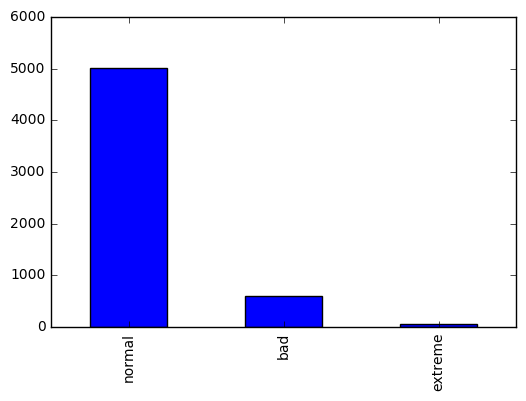

In [13]:
data.category.value_counts().plot(kind='bar')

In [14]:
train,test=train_test_split(data,test_size=0.2,random_state=567)

In [15]:
x_train = train[['Day_length_hr','Avg_Temp_F','Avg_humidity_percent','Avg_windspeed_mph',
             'Max_windspeed_mph','Max_windgust_mph','Precipitation_in','Event_thunderstorm']]
y_train = pd.factorize(train.category)[0]

x_test = test[['Day_length_hr','Avg_Temp_F','Avg_humidity_percent','Avg_windspeed_mph',
             'Max_windspeed_mph','Max_windgust_mph','Precipitation_in','Event_thunderstorm']]
y_test = pd.factorize(test.category)[0]

In [16]:
x_train.head(2)

,Day_length_hr,Avg_Temp_F,Avg_humidity_percent,Avg_windspeed_mph,Max_windspeed_mph,Max_windgust_mph,Precipitation_in,Event_thunderstorm
2246,9.7667,55.0,90.0,9.0,23.0,30.0,0.87,0.0
4170,10.0667,45.0,82.0,8.0,15.0,12.0,0.03,0.0


In [17]:
# data normalization
x_train_nor = pd.DataFrame(preprocessing.normalize(x_train[['Day_length_hr','Avg_Temp_F',
                            'Avg_humidity_percent','Max_windspeed_mph','Max_windgust_mph',
                            'Precipitation_in']]))
x_train_nor = x_train_nor.fillna(0)
x_test_nor = pd.DataFrame(preprocessing.normalize(x_test[['Day_length_hr','Avg_Temp_F',
                            'Avg_humidity_percent','Max_windspeed_mph','Max_windgust_mph',
                            'Precipitation_in']]))
x_test_nor = x_test_nor.fillna(0)

In [18]:
# data standardization
x_train_std = pd.DataFrame(preprocessing.scale(x_train[['Day_length_hr','Avg_Temp_F',
                            'Avg_humidity_percent','Max_windspeed_mph','Max_windgust_mph',
                            'Precipitation_in']]))
x_train_std = x_train_std.fillna(0)
x_test_std = pd.DataFrame(preprocessing.scale(x_test[['Day_length_hr','Avg_Temp_F',
                            'Avg_humidity_percent','Max_windspeed_mph','Max_windgust_mph',
                            'Precipitation_in']]))
x_test_std = x_test_std.fillna(0)

In [19]:
x_train_std.head(2)

,0,1,2,3,4,5
0,-0.924288,0.225724,1.308323,1.336746,1.197937,2.995458
1,-0.808147,-0.733439,0.658883,-0.075630,-0.757733,-0.304913


In [20]:
x_train_nor.head(2)

,0,1,2,3,4,5
0,0.086836,0.489007,0.800193,0.204494,0.266731,0.007735
1,0.104842,0.468665,0.854012,0.156222,0.124977,0.000312


In [21]:
x_train_nor.size

27186

In [22]:
y_test.size

1133

### Decision Tree 

In [23]:
# using balanced class weight will give higher error, but can predict extreme cases better
dt = DecisionTreeClassifier(min_samples_leaf=5,max_depth=3,class_weight='balanced')#class_weight={0:0.05,1:0.05,2:0.9}

clf_nor = dt.fit(x_train_nor,y_train)

y_train_pred_nor = dt.predict(x_train_nor)
y_test_pred_nor = dt.predict(x_test_nor)

print("Train error for normalized data",mean_squared_error(y_train,y_train_pred_nor))
print("Test error for normalized data",mean_squared_error(y_test,y_test_pred_nor))
print("training score for normalized data",dt.score(x_train_nor,y_train))

tree_dot_nor = export_graphviz(clf_nor,out_file = 'tree_all_nor.dot')

Train error for normalized data 0.497903332598
Test error for normalized data 0.533097969991
training score for normalized data 0.525932465239


In [24]:
clf_std = dt.fit(x_train_std,y_train)

y_train_pred_std = dt.predict(x_train_std)
y_test_pred_std = dt.predict(x_test_std)

print("Train error for standardized data",mean_squared_error(y_train,y_train_pred_std))
print("Test error for standardized data",mean_squared_error(y_test,y_test_pred_std))
print("training score for standardized data",dt.score(x_train_std,y_train))

tree_dot_std = export_graphviz(clf_std,out_file = 'tree_all_std.dot')

Train error for standardized data 1.23063341426
Test error for standardized data 1.18976169462
training score for standardized data 0.468549988965


In [25]:
# probability of each event
print(dt.predict_proba(x_train_std)[0:20], y_test[0:20])

[[ 0.34907514  0.28640971  0.36451516]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.34161088  0.60147882  0.05691029]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.34907514  0.28640971  0.36451516]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.2828892   0.7171108   0.        ]
 [ 0.34161088  0.60147882  0.05691029]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.34161088  0.60147882  0.05691029]
 [ 0.34161088  0.60147882  0.05691029]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.34161088  0.60147882  0.05691029]
 [ 0.76948361  0.23051639  0.        ]
 [ 0.34907514  0.28640971  0.36451516]
 [ 0.34161088  0.60147882  0.05691029]
 [ 0.76948361  0.23051639  0.        ]] [0 0 0 0 0 0 0 0 0 1 0 1 0 2 0 0 0 0 0 2]


In [26]:
# View a list of the features and their importance scores
list(zip(x_train_std, dt.feature_importances_))

[(0, 0.14081367409074341),
 (1, 0.083859560154314075),
 (2, 0.026247867041439474),
 (3, 0.58359441278457258),
 (4, 0.0),
 (5, 0.16548448592893047)]

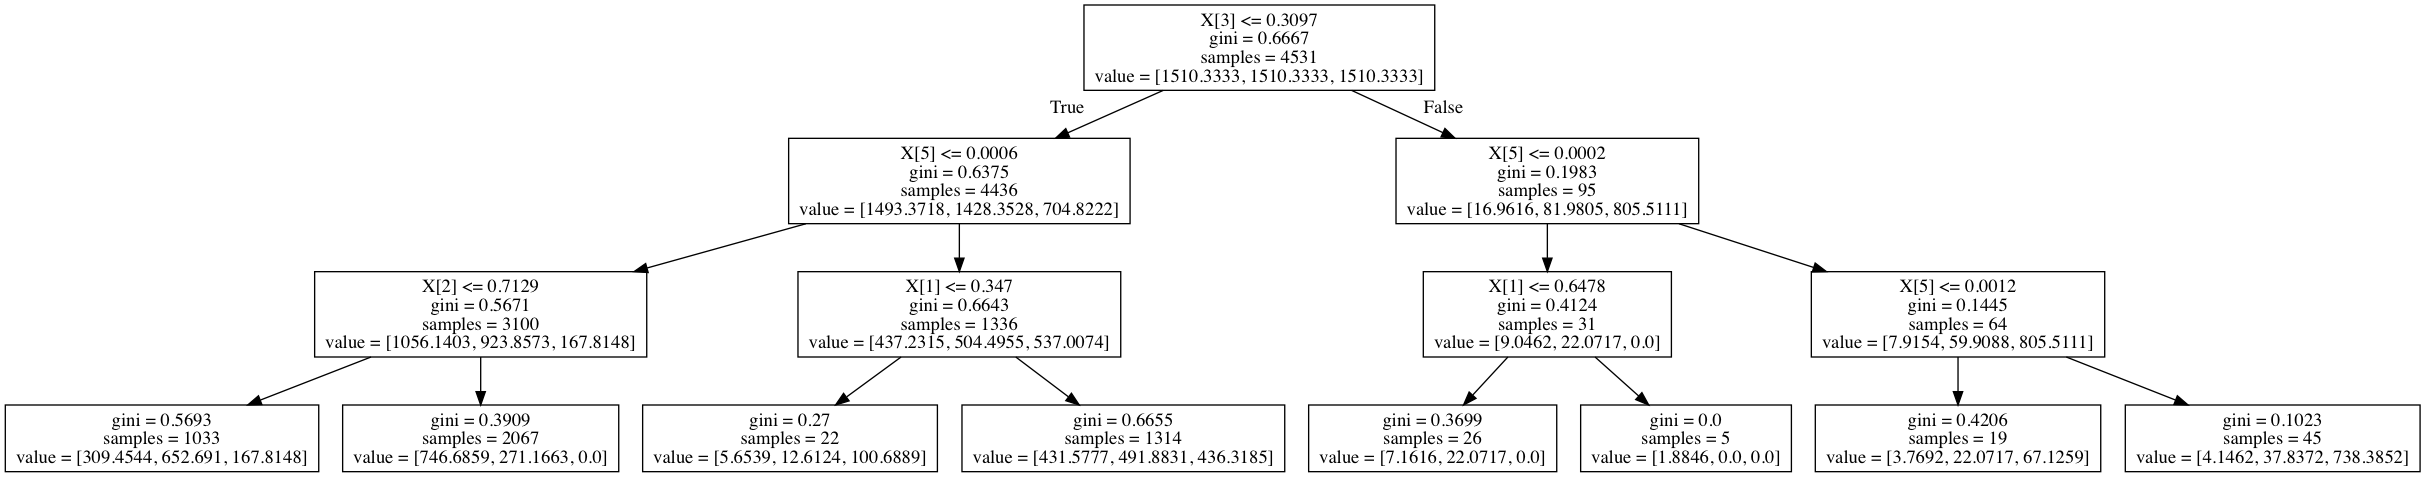

In [27]:
graph = pydotplus.graphviz.graph_from_dot_file('tree_all_nor.dot')
Image(graph.create_png())

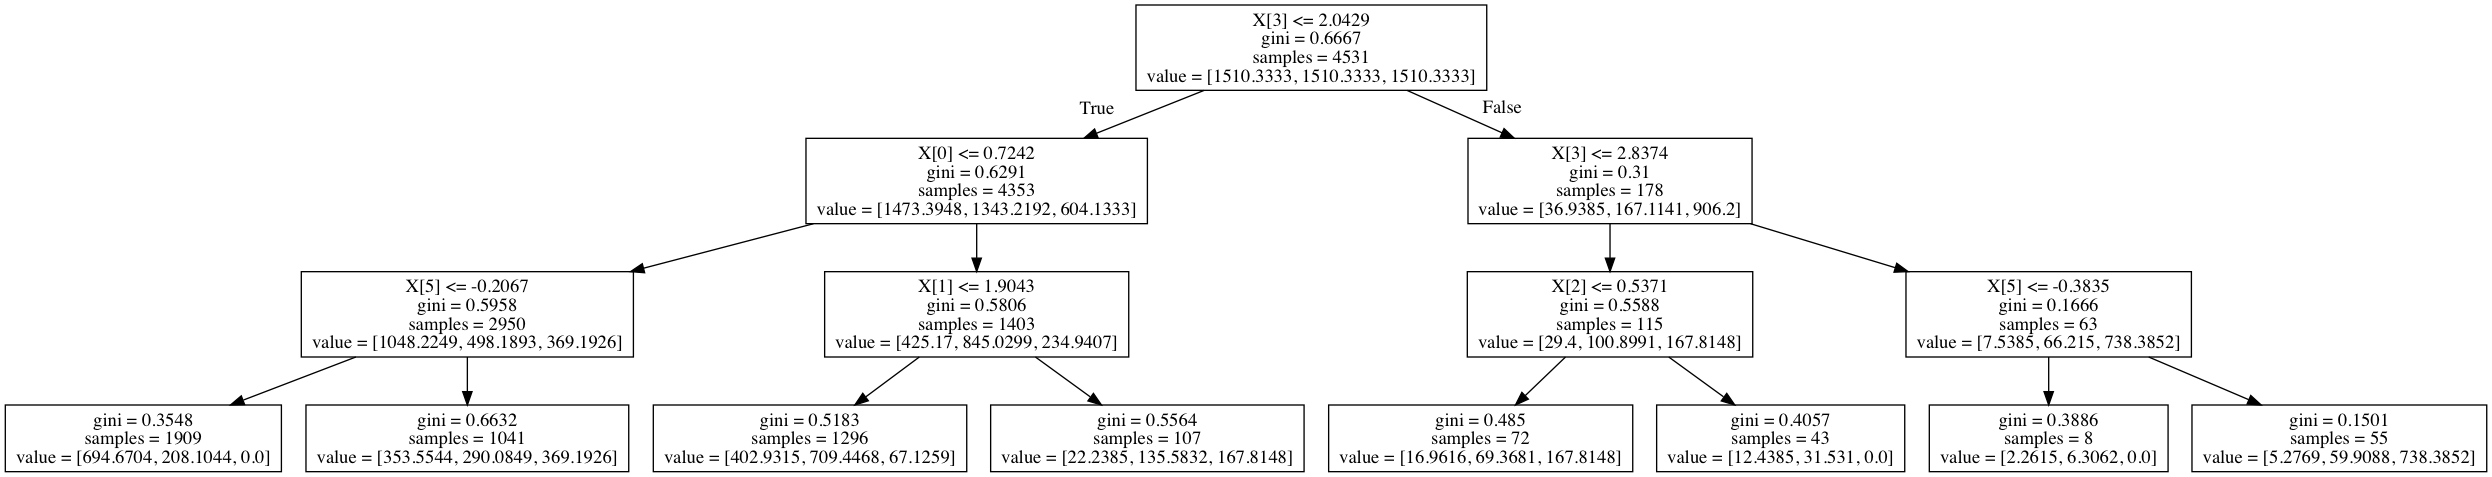

In [28]:
graph = pydotplus.graphviz.graph_from_dot_file('tree_all_std.dot')
Image(graph.create_png())

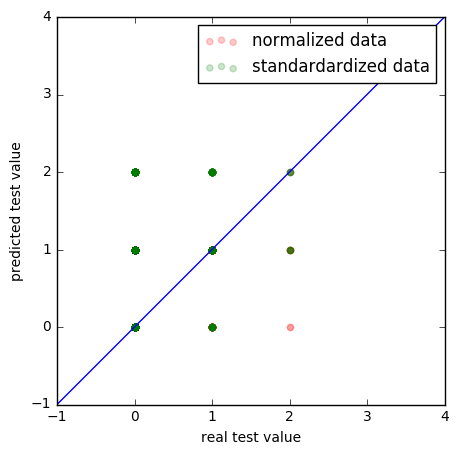

In [29]:
# plot the results
plt.figure(figsize=(5,5))
plt.scatter(y_test,y_test_pred_nor,alpha=0.2,color='red',label='normalized data')
plt.scatter(y_test,y_test_pred_std,alpha=0.2,color='green',label='standardardized data')
plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,4])
plt.ylim([-1,4])
plt.legend()

training score using [0, 3] features is 0.610020
training score using [0, 5] features is 0.460825
training score using [3, 5] features is 0.667182


/Users/Yanbo/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


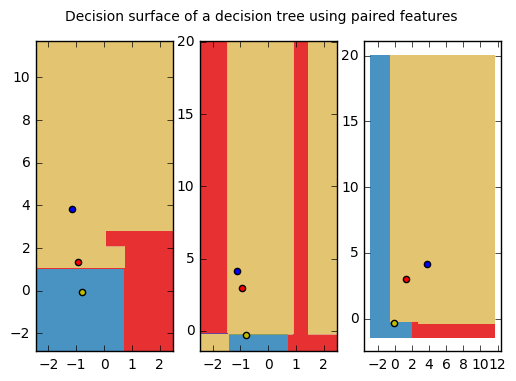

In [30]:
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration
n_classes = 3

for pairidx, pair in enumerate([[0, 3], [0, 5], [3, 5]]):
# We only take the two corresponding features
    X = x_train_std.iloc[:,pair]
    y = y_train

    # Train
    clf = DecisionTreeClassifier(min_samples_leaf=5,max_depth=3,class_weight='balanced').fit(X, y)
    print("training score using %s features is %f" % (pair, clf.score(X,y)))
    # Plot the decision boundary
    plt.subplot(1, 3, pairidx+1)
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    #plt.xlabel(iris.feature_names[pair[0]])
    #plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X.iloc[idx[0][0].tolist(), 0], X.iloc[idx[0][0].tolist(), 1], c=color,
                    cmap=plt.cm.Paired)

plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

### Advanced Tree Methods

### without weights on class

Train error for standardized data using DecisionTree is 0.128889869786
Test error for standardized data using DecisionTree is 0.139452780229
Feature importance using DecisionTree is 
 [(0, 0.35862157482582779), (1, 0.13903795437841926), (2, 0.0), (3, 0.3963255254051074), (4, 0.0), (5, 0.10601494539064554)] 

Train error for standardized data using RandomForest is 0.101302140808
Test error for standardized data using RandomForest is 0.130626654898
Feature importance using RandomForest is 
 [(0, 0.24165266187689932), (1, 0.18500150626967818), (2, 0.13644872808586442), (3, 0.20391763019890791), (4, 0.12732190730965712), (5, 0.105657566258993)] 

Train error for standardized data using ExtraTrees is 0.145442507173
Test error for standardized data using ExtraTrees is 0.137687555163
Feature importance using ExtraTrees is 
 [(0, 0.2115157720032515), (1, 0.22912940752786964), (2, 0.082449847287992734), (3, 0.25153773627115944), (4, 0.084360738725947002), (5, 0.10767316485044631)] 

Train error

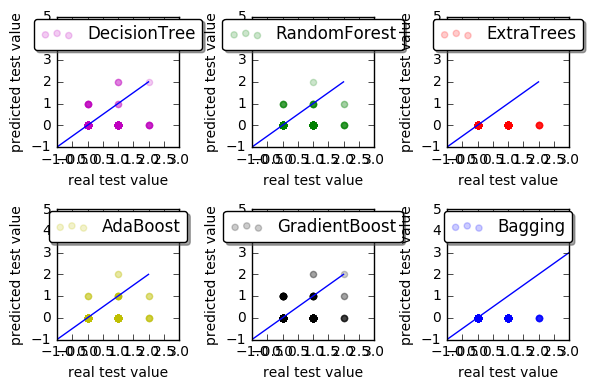

In [31]:
n_estimators = 30 # number of trees used, default=10 for rf, et, 50 for ab, 100 for gb
#n_jobs=-1, the number of jobs is set to the number of cores

dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=5, presort=True)
rf = RandomForestClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1)
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),learning_rate=0.1)
bg = BaggingClassifier(max_samples=3,n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=300, min_samples_leaf=5)

plot_idx = 1
for method, color_, label_ in [(dt,'m','DecisionTree'),(rf,'g','RandomForest'), (et,'r','ExtraTrees'),
                               (ab,'y','AdaBoost'),(gb,'k','GradientBoost')]:
    clf_std = method.fit(x_train_std,y_train)

    y_train_pred_std = method.predict(x_train_std)
    y_test_pred_std = method.predict(x_test_std)

    print("Train error for standardized data using %s is" % (label_),mean_squared_error(y_train,y_train_pred_std))
    print("Test error for standardized data using %s is" % (label_),mean_squared_error(y_test,y_test_pred_std))
    print("Feature importance using %s is" % (label_),'\n',list(zip(x_train_std, method.feature_importances_)),'\n')
    plt.subplot(2, 3, plot_idx)
    plt.scatter(y_test,y_test_pred_std,alpha=0.2,color=color_,label=label_)
    plt.plot(np.arange(-1,3),np.arange(-1,3))
    plt.xlabel('real test value')
    plt.ylabel('predicted test value')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    plt.xlim([-1,3])
    plt.ylim([-1,5])
    plt.tight_layout()
    plot_idx += 1
    
clf_std = bg.fit(x_train_std,y_train)
y_train_pred_std = bg.predict(x_train_std)
y_test_pred_std = bg.predict(x_test_std)
print("Train error for standardized data using %s is" % 'Bagging',mean_squared_error(y_train,y_train_pred_std))
print("Test error for standardized data using %s is" % 'Bagging',mean_squared_error(y_test,y_test_pred_std))

plt.subplot(2, 3, 6)
plt.scatter(y_test,y_test_pred_std,alpha=0.2,color='b',label='Bagging')    

plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,3])
plt.ylim([-1,5])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()

### with weights on class

In [32]:
n_estimators = 30 # number of trees used, default=10 for rf, et, 50 for ab, 100 for gb
#n_jobs=-1, the number of jobs is set to the number of cores

dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=5, 
                            class_weight='balanced', presort=True)
rf = RandomForestClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1,
                            class_weight='balanced')
et = ExtraTreesClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1,
                          class_weight='balanced')
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),learning_rate=0.1)
bg = BaggingClassifier(max_samples=3,n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=300, min_samples_leaf=5)

Train error for standardized data using DecisionTree is 1.23063341426
Test error for standardized data using DecisionTree is 1.18976169462
Feature importance using DecisionTree is 
 [(0, 0.14081367409073683), (1, 0.083859560154305721), (2, 0.038016521144562804), (3, 0.58359441278457125), (4, 0.0), (5, 0.15371583182582346)] 

Train error for standardized data using RandomForest is 0.0712866916795
Test error for standardized data using RandomForest is 0.157987643425
Feature importance using RandomForest is 
 [(0, 0.18292365710118261), (1, 0.16178536538025937), (2, 0.13033357019629194), (3, 0.25481151720950668), (4, 0.10216293431237806), (5, 0.16798295580038136)] 

Train error for standardized data using ExtraTrees is 0.20679761642
Test error for standardized data using ExtraTrees is 0.289496910856
Feature importance using ExtraTrees is 
 [(0, 0.19976982147094538), (1, 0.11938022926361708), (2, 0.088843136981357512), (3, 0.26597641609838768), (4, 0.097014591753916829), (5, 0.1623491377651

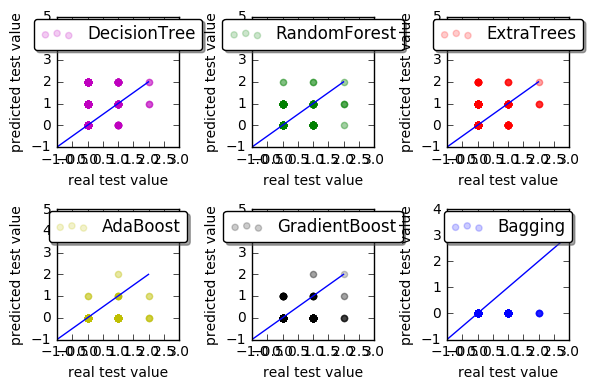

In [33]:
plot_idx = 1
for method, color_, label_ in [(dt,'m','DecisionTree'),(rf,'g','RandomForest'), (et,'r','ExtraTrees'),
                               (ab,'y','AdaBoost'),(gb,'k','GradientBoost')]:
    clf_std = method.fit(x_train_std,y_train)

    y_train_pred_std = method.predict(x_train_std)
    y_test_pred_std = method.predict(x_test_std)

    print("Train error for standardized data using %s is" % (label_),mean_squared_error(y_train,y_train_pred_std))
    print("Test error for standardized data using %s is" % (label_),mean_squared_error(y_test,y_test_pred_std))
    print("Feature importance using %s is" % (label_),'\n',list(zip(x_train_std, method.feature_importances_)),'\n')
    plt.subplot(2, 3, plot_idx)
    plt.scatter(y_test,y_test_pred_std,alpha=0.2,color=color_,label=label_)
    plt.plot(np.arange(-1,3),np.arange(-1,3))
    plt.xlabel('real test value')
    plt.ylabel('predicted test value')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    plt.xlim([-1,3])
    plt.ylim([-1,5])
    plt.tight_layout()
    plot_idx += 1
    
clf_std = bg.fit(x_train_std,y_train)
y_train_pred_std = bg.predict(x_train_std)
y_test_pred_std = bg.predict(x_test_std)
print("Train error for standardized data using %s is" % 'Bagging',mean_squared_error(y_train,y_train_pred_std))
print("Test error for standardized data using %s is" % 'Bagging',mean_squared_error(y_test,y_test_pred_std))

plt.subplot(2, 3, 6)
plt.scatter(y_test,y_test_pred_std,alpha=0.2,color='b',label='Bagging')    

plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,3])
plt.ylim([-1,4])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()

### count correctness for difference classes

In [58]:
df = pd.DataFrame()
for method, label_ in [(dt,'DecisionTree'),(rf,'RandomForest'), (et,'ExtraTrees'),
                               (ab,'AdaBoost'),(gb,'GradientBoost'),(bg,'Bagging')]:
    clf = method.fit(x_train_std,y_train)
    y_pred = method.predict(x_test_std)
    y_test = pd.DataFrame(y_test)
    #initialize counters 
    overall_correctness = 0
    under_predict_normal = 0
    right_predict_normal = 0
    over_predict_normal = 0
    under_predict_bad = 0
    right_predict_bad = 0
    over_predict_bad = 0
    under_predict_extreme = 0
    right_predict_extreme = 0
    over_predict_extreme = 0
    
    for index, row in y_test.iterrows():
        if y_pred[index] == row.values: # predict correctly
            overall_correctness += 1
            if row.values == 0:
                right_predict_normal += 1
            elif row.values == 1:
                right_predict_bad += 1
            else:
                right_predict_extreme += 1
        elif row.values == 0:
            over_predict_normal += 1
        elif row.values == 1:
            if y_pred[index] == 0:
                under_predict_bad += 1
            else:
                over_predict_bad += 1
        else:
            under_predict_extreme += 1
    
    df = df.append({"Method": label_, "Overall_Correctness": overall_correctness/index,
                    "right_predict_normal": right_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "right_predict_bad": right_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "right_predict_extreme": right_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme),
                    "under_predict_normal": under_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "under_predict_bad": under_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "under_predict_extreme": under_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme),
                    "over_predict_normal": over_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "over_predict_bad": over_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "over_predict_extreme": over_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme)},
                  ignore_index=True)
df.to_csv('TreeMet')
df
                
        

,Method,Overall_Correctness,over_predict_bad,over_predict_extreme,over_predict_normal,right_predict_bad,right_predict_extreme,right_predict_normal,under_predict_bad,under_predict_extreme,under_predict_normal
0,DecisionTree,0.459364,0.358333,0.0,0.543825,0.483333,0.444444,0.456175,0.158333,0.555556,0.0
1,RandomForest,0.854240,0.033333,0.0,0.081673,0.358333,0.222222,0.918327,0.608333,0.777778,0.0
2,ExtraTrees,0.769435,0.100000,0.0,0.197211,0.516667,0.333333,0.802789,0.383333,0.666667,0.0
3,AdaBoost,0.892226,0.016667,0.0,0.003984,0.083333,0.000000,0.996016,0.900000,1.000000,0.0
4,GradientBoost,0.883392,0.016667,0.0,0.018924,0.116667,0.111111,0.981076,0.866667,0.888889,0.0
5,Bagging,0.886926,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0
